<a href="https://colab.research.google.com/github/s-serenity/Deep-learning-for-channel-encoding-and-decoding/blob/master/testcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>欢迎使用 Colaboratory！</h1>

Colaboratory 是一个免费的 Jupyter 笔记本环境，不需要进行任何设置就可以使用，并且完全在云端运行。

借助 Colaboratory，您可以编写和执行代码、保存和共享分析结果，以及利用强大的计算资源，所有这些都可通过浏览器免费使用。

In [0]:
#@title Colaboratory 简介
#@markdown 下面这个时长 3 分钟的视频概述了 Colaboratory 的主要功能：
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## 开始使用

您正在阅读的文档是托管在 Colaboratory 中的 [Jupyter 笔记本](https://jupyter.org)。它并非静态页面，而是一个可让您以 Python 和其他语言编写和执行代码的互动环境。

例如，以下**代码单元格**包含一个简短的 Python 脚本，该脚本会计算值、将其存储在变量中并输出结果：

In [0]:
一天的秒数 = 24 * 60 * 60
一天的秒数

86400

要执行上述单元格中的代码，请点击选择它，然后按代码左侧的“播放”按钮，或使用键盘快捷键“⌘/Ctrl+Enter”。

所有单元格都会修改同一全局状态，因此您通过执行某个单元格定义的变量可用在其他单元格中：

In [0]:
一周的秒数 = 7 * 一天的秒数
一周的秒数

604800

## 更多资源

要了解如何充分利用 Python、Jupyter、Colaboratory 和相关工具，请参阅以下资源：

### 机器学习速成课程
以下是可以在 Google 的在线机器学习课程中找到的部分笔记本。请查看[完整课程网站](https://developers.google.com/machine-learning/crash-course/)了解详情。
- [Pandas 简介](/notebooks/mlcc/intro_to_pandas.ipynb)
- [TensorFlow 编程概念](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [使用 TensorFlow 的基本步骤](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [神经网络简介](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [稀疏数据和嵌入简介](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### 机器学习示例：Seedbank

要查看 Colaboratory 实现的交互式机器学习分析的端到端示例，请查看[Seedbank](https://research.google.com/seedbank/)项目。

一些精选示例：

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): 使用深度学习在图像之间转换风格。
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): 使用 WaveNet 自动编码器合成音频。
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): 使用深度学习对时装图像进行分类。
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): 根据您自己的照片生成 DeepDream 图像。
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): 创建手写数字生成模型。

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
[9.99350172e-01 6.87549013e-01 8.32760404e-01 7.12742441e-02
 9.13663420e-01 1.23310493e-01 2.43041496e-01 6.70812721e-04
 9.49666367e-01 1.94504679e-01 3.49340835e-01 1.31738620e-03
 4.98674841e-01 4.05552570e-03 1.68912593e-02 1.12535175e-07]
15
4
1111
0111
1011
1101
1110
0011
0101
1001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
____________________________________________

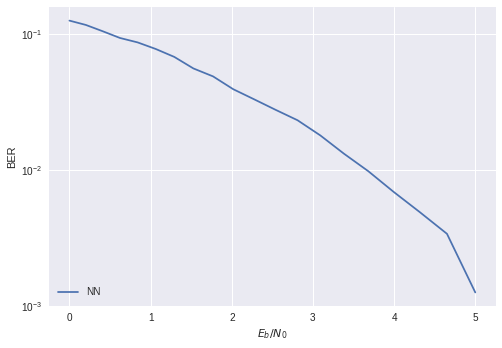

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# parameters
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**16            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# define NN model
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)


def errors(y_true, y_pred):
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),dtype='float16'))

# Define modulator
modulator_layers = [Lambda(modulateBPSK,
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma},
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma},
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)
# Define decoder
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
#decoder.compile(optimizer=optimizer, loss=loss, metrics=[ber])
# Define model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    #print(m)
    n = np.ceil(np.log2(m)).astype(int)
    #print(n)
    for i in range(0,len(x)):
        #print('{:0{n}b}'.format(x[i],n=n))
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),), dtype=int)
        for i in range(0, len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out
        else:
            integer = np.zeros((b.shape[0],), dtype=int)
            for i in range(0, b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out

            return integer


def polar_design_awgn(N, k, design_snr_dB):
    S = 10 ** (design_snr_dB / 10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1, int(np.log2(N)) + 1):
        u = 2 ** j
        for t in range(0, int(u / 2)):
            T = z0[t]
            z0[t] = 2 * T - T ** 2  # upper channel
            z0[int(u / 2) + t] = T ** 2  # lower channel
    #print(z0)
    # sort into increasing order
    idx = np.argsort(z0)
    #print(idx)
    # select k best channels
    #print(bitrevorder(idx[0:k]))
    idx = np.sort(bitrevorder(idx[0:k]))
    #print(idx)
    A = np.zeros(N, dtype=bool)
    A[idx] = True
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0, stages):
        i = 0
        while i < N:
            for j in range(0, n):
                idx = i + j
                x[idx] = x[idx] ^ x[idx + n]
            i = i + 2 * n
        n = 2 * n
    return x


# Create all possible information words
d = np.zeros((2 ** k, k), dtype=bool)
for i in range(1, 2 ** k):
    d[i] = inc_bool(d[i - 1])

# Create sets of all possible codewords (codebook)
if code == 'polar':

    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations
    x = np.zeros((2 ** k, N), dtype=bool)
    u = np.zeros((2 ** k, N), dtype=bool)
    u[:, A] = d
    #print(A)
    #print(d)
    #print(u)
    for i in range(0, 2 ** k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':

    np.random.seed(4267)  # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0, 2, size=(2 ** k, N), dtype=bool)

before = time.time()
# train NN
model.summary()
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
# test NN
test_batch = 1000
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10 * np.log10(k / N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10 * np.log10(k / N)

sigma_start = np.sqrt(1 / (2 * 10 ** (SNR_dB_start_Es / 10)))
sigma_stop = np.sqrt(1 / (2 * 10 ** (SNR_dB_stop_Es / 10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas), dtype=int)
nb_bits = np.zeros(len(sigmas), dtype=int)

for i in range(0, len(sigmas)):

    for ii in range(0, np.round(num_words / test_batch).astype(int)):
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0, 2, size=(test_batch, k))
        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N), dtype=bool)
            u_test = np.zeros((test_batch, N), dtype=bool)
            u_test[:, A] = d_test

            for iii in range(0, test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N), dtype=bool)
            for iii in range(0, test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2 * x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i] * np.random.standard_normal(s_test.shape)
        if LLR:
            y_test = 2 * y_test / (sigmas[i] ** 2)

        # Decoder
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        nb_bits[i] += d_test.size
after = time.time()
print('cost:',after-before)

# plot
legend = []
print(plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits))
print(nb_errors/nb_bits)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN')


plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()
